In [10]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
os.environ["OMP_NUM_THREADS"] = "1"



# 2 - clustering model

In [5]:
customers = pd.read_csv('D:\project\JOB\Customers.csv')
transactions = pd.read_csv('D:\project\JOB\Transactions.csv')

customer_transactions = transactions.groupby("CustomerID").agg(
    TotalSpending=("TotalValue", "sum"),
    TransactionCount=("TransactionID", "count")
).reset_index()


data = pd.merge(customers, customer_transactions, on="CustomerID", how="left")


data.fillna({"TotalSpending": 0, "TransactionCount": 0}, inplace=True)


features = data[['TotalSpending', 'TransactionCount']]


scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


scaled_features_df = pd.DataFrame(scaled_features, columns=['TotalSpending', 'TransactionCount'])


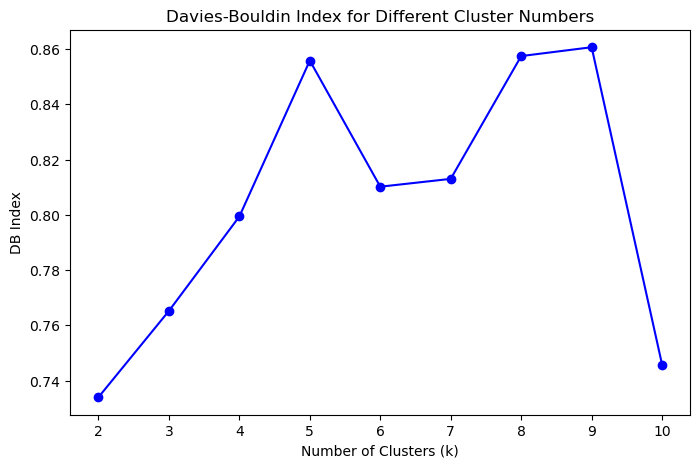

Optimal number of clusters: 2


In [6]:

db_scores = []
k_values = list(range(2, 11))

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_features)
    
  
    db_index = davies_bouldin_score(scaled_features, clusters)
    db_scores.append(db_index)

plt.figure(figsize=(8, 5))
plt.plot(k_values, db_scores, marker='o', color='blue')
plt.title('Davies-Bouldin Index for Different Cluster Numbers')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('DB Index')
plt.show()

optimal_k = k_values[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")


final_kmeans = KMeans(n_clusters=optimal_k, random_state=42)
data['Cluster'] = final_kmeans.fit_predict(scaled_features)


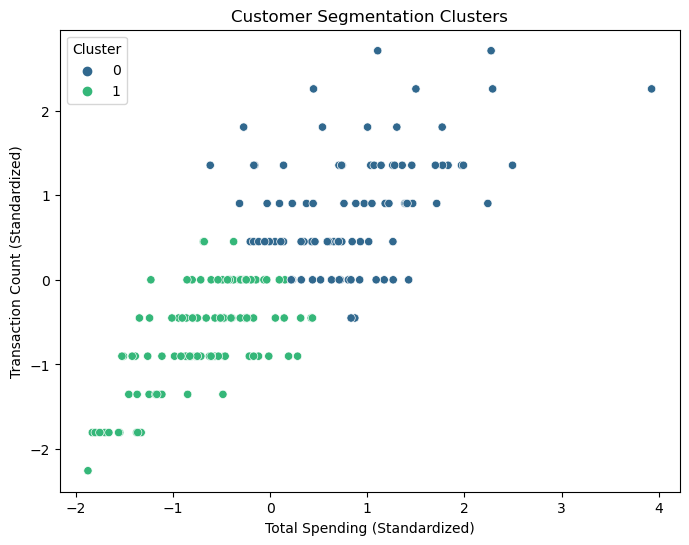

In [7]:

scaled_features_df['Cluster'] = data['Cluster']


plt.figure(figsize=(8, 6))
sns.scatterplot(
    x='TotalSpending', 
    y='TransactionCount', 
    hue='Cluster', 
    data=scaled_features_df, 
    palette='viridis'
)
plt.title('Customer Segmentation Clusters')
plt.xlabel('Total Spending (Standardized)')
plt.ylabel('Transaction Count (Standardized)')
plt.legend(title='Cluster')
plt.show()


In [8]:
# Save clusters with customer IDs
data[['CustomerID', 'Cluster']].to_csv("Customer_Segmentation.csv", index=False)

# Report DB Index and clustering metrics
db_index_final = davies_bouldin_score(scaled_features, data['Cluster'])
print(f"Final DB Index for {optimal_k} clusters: {db_index_final}")


Final DB Index for 2 clusters: 0.7339689917413175


# 3- cluster model

  CustomerID        CustomerName         Region  SignupDate
0      C0001    Lawrence Carroll  South America  2022-07-10
1      C0002      Elizabeth Lutz           Asia  2022-02-13
2      C0003      Michael Rivera  South America  2024-03-07
3      C0004  Kathleen Rodriguez  South America  2022-10-09
4      C0005         Laura Weber           Asia  2022-08-15
  TransactionID CustomerID ProductID      TransactionDate  Quantity  \
0        T00001      C0199      P067  2024-08-25 12:38:23         1   
1        T00112      C0146      P067  2024-05-27 22:23:54         1   
2        T00166      C0127      P067  2024-04-25 07:38:55         1   
3        T00272      C0087      P067  2024-03-26 22:55:37         2   
4        T00363      C0070      P067  2024-03-21 15:10:10         3   

   TotalValue   Price  
0      300.68  300.68  
1      300.68  300.68  
2      300.68  300.68  
3      601.36  300.68  
4      902.04  300.68  


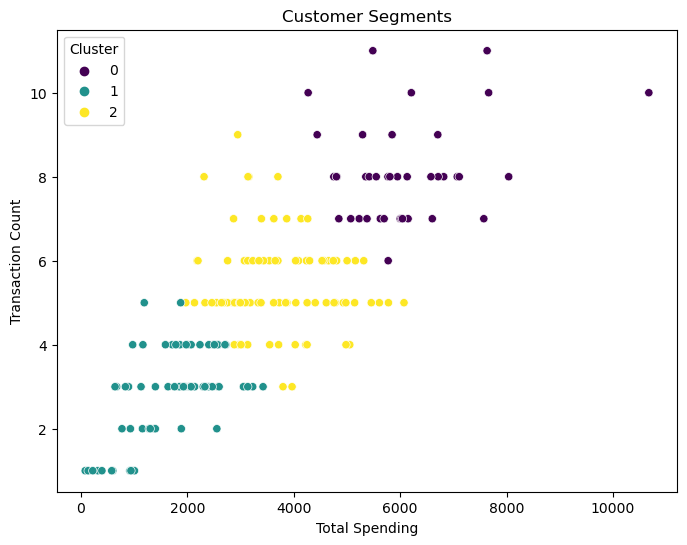

Davies-Bouldin Index: 0.766243150551731
   Cluster  TotalSpending  TransactionCount
0        0    6075.814359          8.102564
1        1    1711.751143          2.842857
2        2    3702.402444          5.388889


In [9]:

customers = pd.read_csv('D:\project\JOB\Customers.csv')
transactions = pd.read_csv('D:\project\JOB\Transactions.csv')

print(customers.head())
print(transactions.head())

merged_data = transactions.merge(customers, on='CustomerID')


merged_data['TotalSpending'] = merged_data['Quantity'] * merged_data['Price']
customer_features = merged_data.groupby('CustomerID').agg({
    'TotalSpending': 'sum',
    'TransactionID': 'count'  
}).reset_index()
customer_features.rename(columns={'TransactionID': 'TransactionCount'}, inplace=True)


scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_features[['TotalSpending', 'TransactionCount']])


kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
labels = kmeans.fit_predict(scaled_data)


customer_features['Cluster'] = labels


plt.figure(figsize=(8, 6))
sns.scatterplot(x=customer_features['TotalSpending'], y=customer_features['TransactionCount'], hue=customer_features['Cluster'], palette="viridis")
plt.title("Customer Segments")
plt.xlabel("Total Spending")
plt.ylabel("Transaction Count")
plt.show()


db_index = davies_bouldin_score(scaled_data, labels)
print(f"Davies-Bouldin Index: {db_index}")


cluster_summary = customer_features.groupby('Cluster').agg({
    'TotalSpending': 'mean',
    'TransactionCount': 'mean'
}).reset_index()
print(cluster_summary)
